---
title: Calculating Customer Acquisition Cost
author: Abdullah Mahmood
date: last-modified
format:
    html:
        theme: cosmo
        css: quarto-style/style.css        
        highlight-style: atom-one        
        mainfont: Palatino
        fontcolor: black
        monobackgroundcolor: white
        monofont: Menlo, Lucida Console, Liberation Mono, DejaVu Sans Mono, Bitstream Vera Sans Mono, Courier New, monospace
        fontsize: 13pt
        linestretch: 1.4
        number-sections: true
        number-depth: 5
        toc: true
        toc-location: right
        toc-depth: 5
        code-fold: true
        code-copy: true
        cap-location: bottom
        format-links: false
        embed-resources: true
        anchor-sections: true
        code-links:   
        -   text: GitHub Repo
            icon: github
            href: https://github.com/abdullahau/customer-analytics/
        -   text: Quarto Markdown
            icon: file-code
            href: https://github.com/abdullahau/customer-analytics/blob/main/buyer-behavior-summary-transaction-log.qmd
        html-math-method:
            method: mathjax
            url: https://cdn.jsdelivr.net/npm/mathjax@3/es5/tex-mml-chtml.js
---

Source: [Video Series - Customer Acquisition Cost (by Dan McCarthy)](https://www.youtube.com/watch?v=PZe6LUAyREQ)

## Doing the CACulation

*Main aspects to account for*

1. Repeat sales/marketing should be excluded from CAC
2. Lead-lag between spend and aquisition
3. CAC expense is more than ad spend

*Outline*

1. Unadjusted S&M CAC
2. Unadjusted Acquisition-related S&M CAC
3. Lag-adjusted Acquisition-related S&M CAC
4. Lag-adjusted Acquisition-related Total CAC

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%config InlineBackend.figure_formats = ['svg']

### Import Data

**Younger Eats**

Younger Eats is a fast-growing meal kit company, specializing in meals for young children. 

#### Sales and Marketing Expense data (in *\$ Thousands*):

In [2]:
# Sales and marketing expenses
snm_exp = pd.read_csv("data/CAC-data.csv")

snm_exp['Total Sales and Marketing'] = (
    snm_exp.sum(axis=1) - 
    snm_exp['Acquisition-related onboarding expense'] - 
    snm_exp['Month']
)
snm_exp

,Month,Referral program (marketing),TV ads,OOH,New customer promotions (marketing),Facebook ads for acquisition,Facebook ads for repeat orders,Google ads for acquisition,Google ads for repeat orders,Prospecting sales team,Account manager team,Acquisition-related onboarding expense,Total Sales and Marketing
0,1,5.000000,60.000000,5.000000,10.0,40.000000,80.000000,40.000000,80.000000,50.000000,100.000000,40.0000,470.000000
1,2,5.150000,62.400000,5.150000,13.0,42.000000,83.200000,42.000000,83.200000,55.000000,104.000000,52.0000,495.100000
2,3,5.304500,64.896000,5.304500,16.0,44.100000,86.528000,44.100000,86.528000,60.500000,108.160000,64.0000,521.421000
3,4,5.463635,67.491840,5.463635,19.0,46.305000,89.989120,46.305000,89.989120,66.550000,112.486400,76.0000,549.043750
4,5,5.627544,70.191514,5.627544,22.0,48.620250,93.588685,48.620250,93.588685,73.205000,116.985856,88.0000,578.055327
5,6,5.796370,72.999174,5.796370,25.0,51.051262,97.332232,51.051262,97.332232,80.525500,121.665290,100.0000,608.549694
6,7,5.970261,75.919141,5.970261,28.0,53.603826,101.225521,53.603826,101.225521,88.578050,126.531902,112.0000,640.628310
7,8,6.149369,78.955907,6.149369,31.0,56.284017,105.274542,56.284017,105.274542,97.435855,131.593178,124.0000,674.400797
8,9,6.333850,82.114143,6.333850,34.0,59.098218,109.485524,59.098218,109.485524,107.179440,136.856905,136.0000,709.985673
9,10,6.523866,85.398709,6.523866,37.0,62.053129,113.864945,62.053129,113.864945,117.897385,142.331181,148.0000,747.511154


The data contains the following channels:

- Referral Program
- TV Advertising
- Out-of-Home (OOH) Advertising / Outdoor Advertising
- New Customer Promotions
- Facebook Ads for Acquistion
- Facebook Ads for Repeat Orders
- Google Ads for Acquistion
- Google Ads for Repeat Orders
- Prospecting Sales Team
- Account Manager Team
- Acquistion-Related Onboarding Expense

We note that the following features about the channels:

- TV Ads: Spend equally impacts customer acquisition in current and subsequent 3 months. 80% earmarked for customer acquisition.
- OOH: Spend equally impacts customer acquisition in current and subsequent 2 months. 80% earmarked for customer acquisition.
- Prospecting Sales Team: 3-month lag, on average, between sales activity and adoption
- Account Manager Team: This team facilitates transactions from existing accounts
- Acquisition-Related Onboarding Expenses: 2-month lead -- money is spent for customers acquired 2 months ago

#### Customer Acquistions Data (in *Thousands*) - Last Touch Attribution:

In [3]:
# Acquisitions (last touch attribution)
acquisitions = pd.read_csv('data/CAC-Acquisition-Data.csv')
acquisitions['Total Acquisitions'] = (
    acquisitions.sum(axis=1) - 
    acquisitions['Month']
)
acquisitions

,Month,Referral program,Facebook ads for acquisition,Google ads for acquisition,Prospecting sales team,Organic / otherwise unattributable,Total Acquisitions
0,1,0.200000,0.500000,0.571429,0.500000,3.178571,4.950000
1,2,0.206000,0.525000,0.600000,0.550000,3.424500,5.305500
2,3,0.212180,0.551250,0.630000,0.605000,3.682215,5.680645
3,4,0.218545,0.578812,0.661500,0.665500,3.952661,6.077019
4,5,0.225102,0.607753,0.694575,0.732050,4.078418,6.337898
5,6,0.231855,0.638141,0.729304,0.805255,4.205448,6.610003
6,7,0.238810,0.670048,0.765769,0.885780,4.498200,7.058608
7,8,0.245975,0.703550,0.804057,0.974359,4.806996,7.534937
8,9,0.253354,0.738728,0.844260,1.071794,4.946163,7.854300
9,10,0.260955,0.775664,0.886473,1.178974,5.278640,8.380706


## CAC Measurements

### Unadjusted Sales & Marketing CAC

Computed as *Total Sales & Marketing Cost / Total Acquisitions*

In [4]:
# Unadjusted sales and marketing CAC
unadj_snm_cac = snm_exp['Total Sales and Marketing'][:-2] / acquisitions['Total Acquisitions']
unadj_snm_cac

0     94.949495
1     93.318255
2     91.789049
3     90.347552
4     91.206165
5     92.064972
6     90.758448
7     89.503177
8     90.394522
9     89.194298
10    88.028365
11    88.913036
dtype: float64

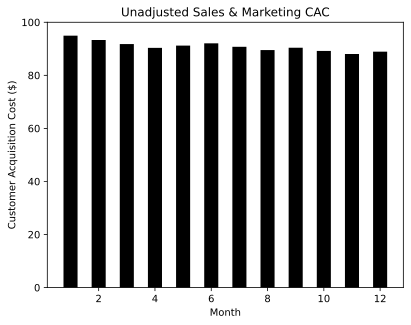

In [13]:
plt.bar(x=unadj_snm_cac.index+1, height=unadj_snm_cac, color='k', width=0.5)
plt.ylim(0, 100)
plt.xlabel('Month')
plt.ylabel('Customer Acquisition Cost ($)')
plt.title('Unadjusted Sales & Marketing CAC');

### Unadjusted Acquisition-related S&M CAC

Computed as *Unadjusted Acquisition-Related Sales & Marketing Cost / Total Acquisitions*

In [6]:
# Unadjusted acquisition-related sales and marketing ($k)
unadj_acq_cost = (
    snm_exp['Referral program (marketing)'] +
    snm_exp['TV ads'] * 0.8 +
    snm_exp['OOH'] * 0.8 +
    snm_exp['New customer promotions (marketing)'] +
    snm_exp['Facebook ads for acquisition'] + 
    snm_exp['Google ads for acquisition'] + 
    snm_exp['Prospecting sales team']
)
unadj_acq_cost

0     197.000000
1     211.190000
2     226.164900
3     241.988015
4     258.728290
5     276.460831
6     295.267485
7     315.237479
8     336.468121
9     359.065568
10    383.145666
11    408.834883
12           NaN
13           NaN
dtype: float64

In [10]:
unadj_acq_cac = unadj_acq_cost[:-2] / acquisitions['Total Acquisitions']
unadj_acq_cac

0     39.797980
1     39.805862
2     39.813243
3     39.820187
4     40.822416
5     41.824618
6     41.830837
7     41.836777
8     42.838716
9     42.844312
10    42.849701
11    43.851527
dtype: float64

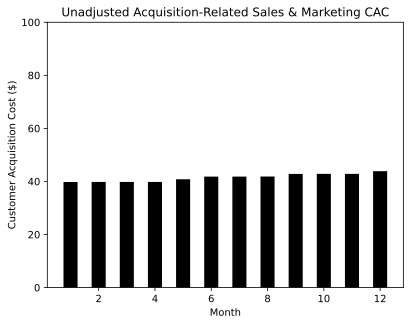

In [14]:
plt.bar(x=unadj_acq_cac.index+1, height=unadj_acq_cac, color='k', width=0.5)
plt.ylim(0, 100)
plt.xlabel('Month')
plt.ylabel('Customer Acquisition Cost ($)')
plt.title('Unadjusted Acquisition-Related Sales & Marketing CAC');

### Lag-adjusted Acquisition-related S&M CAC